In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

# 讀取資料
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 備份 PassengerId 以供輸出
passenger_ids = test_df["PassengerId"]

# 加上標記以便合併資料做前處理
train_df["is_train"] = 1
test_df["is_train"] = 0
test_df["Transported"] = np.nan # 為 test_df 增加 Transported 欄位，方便合併
combined = pd.concat([train_df, test_df], sort=False)

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# --- 特徵工程 ---
# 乘客編號類似 0001_01，這邊透過 GroupId 判定是否同一家庭或同行者。
combined['GroupId'] = combined['PassengerId'].str.split("_").str[0]

# 填補 HomePlanet 和 Cabin 的缺失值，基於 GroupId
combined['HomePlanet'] = combined.groupby('GroupId')['HomePlanet'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
)
combined['Cabin'] = combined.groupby('GroupId')['Cabin'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
)

In [3]:
# --- 處理缺失的消費欄位，基於 CryoSleep ---
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# 確保 CryoSleep 是字串類型，先填補缺失值
combined['CryoSleep'] = combined['CryoSleep'].fillna('False').astype(str)
for col in spending_columns:
    combined[col] = combined.apply(
        lambda row: 0 if row['CryoSleep'] == 'True' and pd.isna(row[col]) else 
        row[col] if not pd.isna(row[col]) else 
        combined[col].median(), axis=1
    )

In [4]:
# --- 從 Cabin 提取特徵 ---
combined[["Deck", "CabinNum", "Side"]] = combined["Cabin"].str.split("/", expand=True)
combined["CabinNum"] = pd.to_numeric(combined["CabinNum"], errors='coerce')

# --- 創建 GroupSize 特徵 ---
group_size = combined.groupby('GroupId')['PassengerId'].transform('count')
combined['GroupSize'] = group_size

# --- 計算 TotalSpend ---
combined["TotalSpend"] = combined[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

# --- 處理 VIP 欄位，統一為字串 ---
combined['VIP'] = combined['VIP'].fillna('False').astype(str)  # 直接填補為字串 'False'，不再轉為布林值

In [5]:
# --- 確保所有類別欄位為字串型態 ---
categorical_cols = ["HomePlanet", "Destination", "Deck", "Side", "CryoSleep", "VIP"]
for col in categorical_cols:
    combined[col] = combined[col].astype(str)  # 強制轉為字串

# --- 數值和類別欄位 ---
numerical_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalSpend", "CabinNum", "GroupSize"]

In [6]:
# --- 2. 準備 Pipeline 中的轉換器 (使用 ColumnTransformer 和 OneHotEncoder) ---

# 數值型特徵的處理：填補為中位數，然後進行標準化
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # 缺失值補中位數
    ('scaler', StandardScaler()) # 標準化（均值=0，標準差=1）
])

# 類別型特徵的處理：填補為 'Missing'，然後進行 OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing_Category')), # 類別特徵先補值成 Missing_Category
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # 用 OneHotEncoder 做向量轉換，模型才看得懂
])

# 使用 ColumnTransformer 將不同的轉換器應用到不同的欄位
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop' # Drop columns not specified
)

# 拆分回訓練與測試集
train_processed = combined[combined["is_train"] == 1]
test_processed = combined[combined["is_train"] == 0]

# 特徵欄位與目標欄位
# X 和 X_test 現在將透過 preprocessor 進行轉換
X = train_processed[numerical_cols + categorical_cols]
y = train_processed["Transported"].astype(int) # Ensure y is int for Keras binary_crossentropy
X_test = test_processed[numerical_cols + categorical_cols]

# --- 將前處理整合到 Keras 模型訓練前 ---
# 在訓練模型前，先對 X 和 X_test 進行轉換
X_transformed = preprocessor.fit_transform(X)
X_test_transformed = preprocessor.transform(X_test)

# 建立神經網路模型
model = Sequential()

# 輸入層和第一個隱藏層：使用 64 個神經元，並添加 Dropout 層來防止過擬合
# input_dim 需根據前處理後的特徵數量來設定
model.add(Dense(units=64, input_dim=X_transformed.shape[1], activation='relu'))
model.add(Dropout(0.3)) # 0.3 是個不錯的起始值，可以調整

# 添加第二層隱藏層
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

# 輸出層：二分類問題，使用 sigmoid 激活函數
model.add(Dense(units=1, activation='sigmoid'))

# 編譯模型
# 學習率可以根據需要調整 (例如：Adam(learning_rate=0.001))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
# epochs 和 batch_size 可以調整。validation_split 用於在訓練過程中監控模型性能。
print("\n--- Training Neural Network Model ---")
history = model.fit(X_transformed, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 預測
predictions = model.predict(X_test_transformed)
predictions = (predictions > 0.5).astype(int) # 將機率轉換為 0 或 1

# 輸出結果
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Transported": predictions.flatten().astype(bool) # 確保 Transported 是布林值
})

# 儲存為 submission.csv
submission_filename = "submission_nn_improved.csv"
submission.to_csv(submission_filename, index=False)
print(f"\n已儲存 {submission_filename}")

c:\Users\Henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training Neural Network Model ---
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6408 - loss: 0.6147 - val_accuracy: 0.7654 - val_loss: 0.4846
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7768 - loss: 0.4797 - val_accuracy: 0.7562 - val_loss: 0.4844
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7863 - loss: 0.4431 - val_accuracy: 0.7821 - val_loss: 0.4559
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7962 - loss: 0.4232 - val_accuracy: 0.7688 - val_loss: 0.4801
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8042 - loss: 0.4155 - val_accuracy: 0.7780 - val_loss: 0.4694
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8031 - loss: 0.4065 - val_accuracy: 0.7694 - val_loss: 0.5000
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7995 - loss: 0.4141 - val_accuracy: 0.7688 - val_loss: 0.5163
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0

In [12]:
# 建 GroupId 和 GroupSize
train_df["GroupId"] = train_df["PassengerId"].str.split("_").str[0]
train_df["GroupSize"] = train_df.groupby("GroupId")["PassengerId"].transform("count")

# 建 TotalSpend
spending_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
train_df["TotalSpend"] = train_df[spending_cols].sum(axis=1)

# 確保 Transported 是數值欄位（不是 bool）
train_df["Transported"] = train_df["Transported"].astype(float)


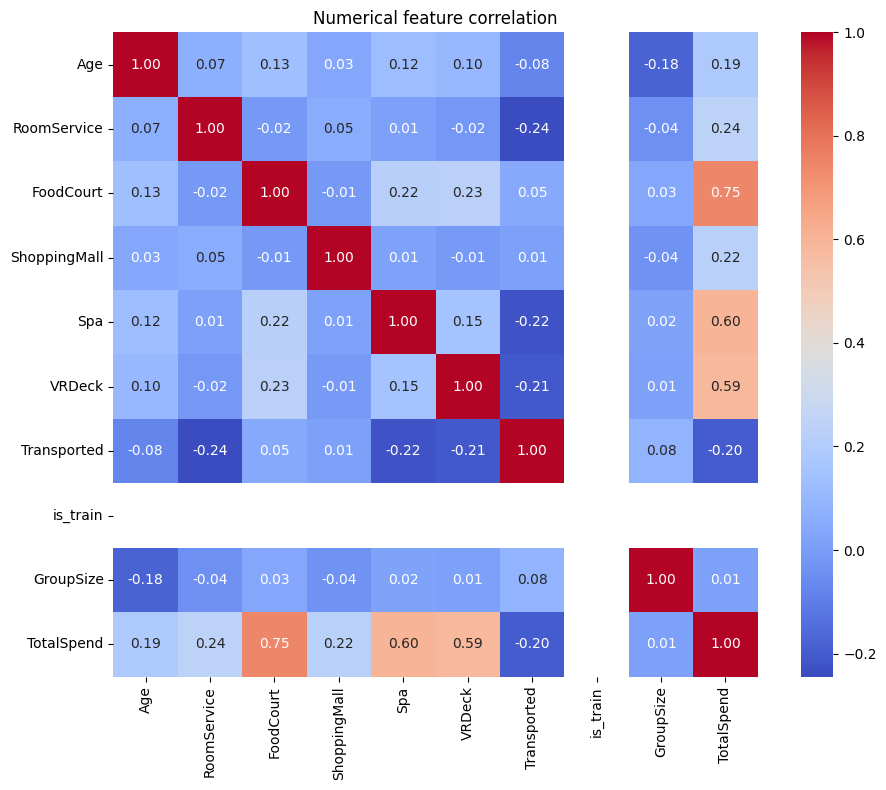

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 選擇數值欄位
numeric_cols = train_df.select_dtypes(include=[np.number])

# 計算相關性矩陣
corr_matrix = numeric_cols.corr()

# 繪製熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Numerical feature correlation")
plt.tight_layout()
plt.show()